In [1]:
import cv2
import numpy as np
import pandas as pd
import torch
import os
import time
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import torchvision.transforms as tf
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict

torch.cuda.empty_cache()


In [2]:
###Image Prep

In [3]:
###Functions 

def splitter(dataset,split=(70,15,15),seed=None):

    assert sum(split)==100

    dataset_length = len(dataset)
    
    if seed != None:
        np.random.seed(seed)
        
    train_data = []
    valid_data = []
    test_data = []
        
    for i in range(0,len(dataset)):
      
        chance = np.random.randint(0,100)

        if chance < split[0]:
            train_data.append(dataset[i,])
            
        elif chance >= split[0] and chance < (split[0]+split[1]):
            valid_data.append(dataset[i,])
        
        elif chance >= (split[0]+split[1]) and chance < sum(split): 
            test_data.append(dataset[i,])
            
        else: 
            print(chance)
  
    return np.array(train_data), np.array(valid_data), np.array(test_data)
        
    
def showRandomSamples(dataset,path='DATA/Images/destination/',seed=42):
    
    pick = np.random.randint(0,len(dataset),size=1)
    
    fig = plt.figure()
    
    #ax = fig.subplots(1,4)
    
    #for i,i_img in enumerate(pick):
        
     #   ax = fig.add_subplot(1,1,(i+1))
    img = dataset[pick]['image']
    plt.imshow(img)
    
    return none

def dynDevice():
    if torch.cuda.device_count() == 0:
        device = 'cpu'
    elif torch.cuda.device_count() > 0:
        device = 'cuda'
        nDevice = torch.cuda.device_count()  #setup for later implementation of multi gpu parallel processing
    return device

print(dynDevice())

  
def inv_normalize(x):
    
    
    
    return x

cuda


In [4]:
annotations = pd.read_csv('Garth_ML_index.csv')
#annotations_good.drop(['Unusable', 'Moderately good'], axis=1, inplace=True)
quality = np.array(np.arange(0,len(annotations)))

for i in range(0,len(quality)):
    if not np.isnan(annotations['Unusable'][i]):
        quality[i]=0
    elif not np.isnan(annotations['Moderately good'][i]):
        quality[i]= 1
    elif not np.isnan(annotations['Good-number of layers'][i]):
        quality[i] = 2

def cats(x):
    if x == 0:
        return 'bad'
    if x == 1:
        return 'mediocre'
    if x == 2:
        return 'good'
    
annotations_class = annotations.copy()
annotations_class['quality'] = quality
annotations_class['cats'] = annotations_class['quality'].apply(cats)
annotations_class['cats'] = annotations_class['cats'].astype('category')

print(len(annotations_class))

annotations_class.head()




16896


,File Name,Unusable,Moderately good,Good-number of layers,quality,cats
0,"Garth_A01_G006_0001[0,0].jpg",1.0,NaN,NaN,0,bad
1,"Garth_A01_G006_0001[0,1].jpg",1.0,NaN,NaN,0,bad
2,"Garth_A01_G006_0001[0,2].jpg",1.0,NaN,NaN,0,bad
3,"Garth_A01_G006_0001[0,3].jpg",1.0,NaN,NaN,0,bad
4,"Garth_A01_G006_0001[0,4].jpg",1.0,NaN,NaN,0,bad


In [5]:
print(annotations_class['cats'].cat.categories)
annotations_class_good = annotations_class[annotations_class['quality']==2]

print(len(annotations_class_good))

annotations_class_good.head()


Index(['bad', 'good', 'mediocre'], dtype='object')
2153


,File Name,Unusable,Moderately good,Good-number of layers,quality,cats
61,"Garth_A01_G006_0001[7,5].jpg",NaN,NaN,3.0,2,good
71,"Garth_A01_G006_0002[0,7].jpg",NaN,NaN,4.0,2,good
74,"Garth_A01_G006_0002[1,2].jpg",NaN,NaN,3.0,2,good
75,"Garth_A01_G006_0002[1,3].jpg",NaN,NaN,3.0,2,good
78,"Garth_A01_G006_0002[1,6].jpg",NaN,NaN,3.0,2,good


In [6]:
###Setup Model

In [6]:
class TwoModelA(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = torch.nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        self.conv3 = torch.nn.Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = torch.nn.Linear(in_features=24*24*9, out_features=512, bias=True)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=128, bias=True)
        self.fc3 = torch.nn.Linear(in_features=128, out_features=3, bias=True)
        

        

    def forward(self,x):
        
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
        x = F.elu(self.conv3(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
        x = F.max_pool2d(x,kernel_size=2,stride=2).view(-1,24*24*9)
        x = F.elu(self.fc1(x))
        x = F.relu(self.fc2(F.dropout(x,p=0.2)))
        x = self.fc3(F.dropout(x,p=0.2))
        return F.log_softmax(x,dim=1)
    
    


modelA =TwoModelA()

print(modelA)

total=0
for param in modelA.parameters():
    total+=param.numel()
    print(param.numel())

print('________________')
print(total)


criterionA = torch.nn.CrossEntropyLoss() 
optimizerA = torch.optim.AdamW(modelA.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)


TwoModelA(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)
75
3
450
6
1350
9
2654208
512
65536
128
384
3
________________
2722664


In [7]:
class TwoModelB(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = torch.nn.Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
        self.conv3 = torch.nn.Conv2d(9, 12, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = torch.nn.Linear(in_features=24*24*12, out_features=512, bias=True)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=128, bias=True)
        self.fc3 = torch.nn.Linear(in_features=128, out_features=1, bias=True)
        

        

    def forward(self,x):
        
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
        x = F.elu(self.conv3(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
        x = F.max_pool2d(x,kernel_size=2,stride=2).view(-1,24*24*12)
        x = F.elu(self.fc1(x))
        x = F.relu(self.fc2(F.dropout(x,p=0.2)))
        x = self.fc3(F.dropout(x,p=0.2))
        return x
    
    


modelB = TwoModelB()

print(modelB)

total=0
for param in modelB.parameters():
    total+=param.numel()
    print(param.numel())

print('________________')
print(total)

criterionB = torch.nn.SmoothL1Loss()
optimizerB = torch.optim.AdamW(modelB.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)

alexnet = models.alexnet(pretrained=False)
#for param in alexnet.parameters():
#    param.requires_grad = False

alexnet.classifier = torch.nn.Sequential(torch.nn.Linear(9216, 1024), #ALTERNATIVELY w ORdered Dic: nn.Sequential(OrderedDict([ ('conv1', nn.Conv2d(1,20,5)),('', nn.),...]))
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.4),
                                 torch.nn.Linear(1024, 1))

criterionB = torch.nn.SmoothL1Loss()
optimizerB = torch.optim.AdamW(alexnet.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)

print(alexnet)

TwoModelB(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(9, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=6912, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
450
6
1350
9
2700
12
3538944
512
65536
128
128
1
________________
3609776
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_s

In [22]:
(((224-4)/2-4)/2-4)/2

24.5

In [23]:
###Custom Data Loader

class customDs(Dataset):
    
    def __init__(self,dataset, mode,path = 'DATA/Images/destination/', transforms=None):
        
        self.dataset = dataset
        self.transforms = transforms
        self.path = path
        self.mode = mode #quality or layers
        
        return None
    
    def __len__(self):
        return len(self.dataset)
      
    def __getitem__(self,idx):

        image = Image.open(self.path+self.dataset[idx][0])
        quality =self.dataset[idx][4]
        
       
        
        ##Encode for ML##
        
        if self.transforms!=None:
            image = self.transforms(image)
            
        if self.mode == 'quality':
            sample = (image,quality)
    
        elif self.mode =='layers':
            assert quality==2, 'Dataset contains images of bad quality; training will fail'
            n_layers = self.dataset[idx][3] if not np.isnan(self.dataset[idx][3]) else self.dataset[idx][2] if not np.isnan(self.dataset[idx][2]) else 0
            sample = (image,n_layers) 

        else:
            print('mode unknown; only accepts "quality" or "layers"')
        
        return sample

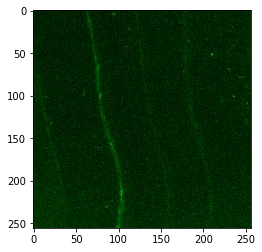

In [24]:
path = 'DATA/Images/destinations/'
img = cv2.imread('DATA/Images/destination/Garth_A01_G006_0220[0,1].jpg')
plt.imshow(img)

#img = torch.tensor(img)
#comp = make_grid(torch.stack([img,img,img]))
#plt.imshow(np.transpose(comp.numpy(),(1,2,0)))

In [25]:
#train-valid-test split = 70%, 15%, 15%
np.random.seed(42)
ann_trainA, ann_validA, ann_testA = splitter(annotations_class.values,(70,15,15))
ann_trainB, ann_validB, ann_testB = splitter(annotations_class_good.values,(70,15,15))

print(len(ann_trainA),len(ann_trainB))
print(len(ann_validA),len(ann_validB))
print(len(ann_testA),len(ann_testB))

11821 1533
2520 305
2555 315


In [26]:
tf_trainDs = customDs(ann_trainA,mode = 'quality',transforms=tf.Compose([
                                               tf.Grayscale(num_output_channels=1),
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomVerticalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.05, p=0.05, interpolation=3),
                                               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.ToTensor(),
                   #                            tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

                          

tf_validDs = customDs(ann_validA,mode = 'quality',transforms=tf.Compose([
                                               tf.Grayscale(num_output_channels=1),
                               #                tf.RandomHorizontalFlip(p=0.5),
                               #                tf.RandomVerticalFlip(p=0.5),
                               #                tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                               #                tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.ToTensor(),
                  #                             tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

tf_testDs = customDs(ann_testA,mode = 'quality',transforms=tf.Compose([
                                               tf.Grayscale(num_output_channels=1),
                                #               tf.RandomHorizontalFlip(p=0.5),
                                #               tf.RandomVerticalFlip(p=0.5),
                                #               tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                                #               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.ToTensor(),
                     #                          tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))


batchSize = 2
train_loader = DataLoader(tf_trainDs, batch_size = batchSize, pin_memory=True, drop_last=True,shuffle=True, num_workers=0)
valid_loader = DataLoader(tf_validDs, batch_size = batchSize, pin_memory=False, drop_last=True, shuffle=True, num_workers=0)
test_loader = DataLoader(tf_testDs, batch_size = batchSize, pin_memory=False, drop_last=True, shuffle=True, num_workers=0)

tensor([1, 0])


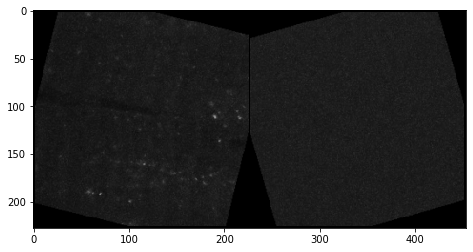

In [27]:
for img, label in train_loader:
    break
    
im = make_grid(img,nrow=12)
plt.figure(figsize=(12,4))
print(label)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [28]:
torch.cuda.empty_cache()
modelA.to(device = dynDevice())

TwoModelA(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [29]:
epochs = 0
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []



for i in range(0,epochs): 
    
    epoch_start = time.time()
    i=0
    losses=0
    accuracies=0

    modelA.train()
    for img, label in train_loader:
        i+=1
        img, label = img.to(device = dynDevice()), label.to(device = dynDevice())
        result = modelA(img)
        loss = criterionA(result,label)
        losses+=loss.item()
        
        #Accuracies: is the quality well constrained? if so, are the layers correctly determined? 
        accuracies+= (result.argmax(dim=1) == label).sum().item()        

   #     if i%500 ==0:
   #         print(f'Training BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies[0]/i}')
   #         break
        
        
        #Update Model
        optimizerA.zero_grad()
        loss.backward()
        optimizerA.step()
       
    training_losses.append(losses/i) 
    training_accuracies.append(accuracies/(i*batchSize))
    training_end =time.time()

    #Validate
    i=0
    losses=0
    accuracies=0
    modelA.eval()
    with torch.no_grad():
        for img, label in valid_loader:
            i+=1
            img, label = img.to(device = dynDevice()), label.to(device = dynDevice())
            result = modelA(img)
            loss = criterionA(result,label)
            losses+=loss.item()
            accuracies+= (result.argmax(dim=1) == label).sum().item()        


        
        validation_losses.append(losses/i)   
        validation_accuracies.append(accuracies/(i*batchSize))
        validation_end = time.time()
    
    print(f'The epoch took {(validation_end-epoch_start):.0f}s. \n    training took {(training_end-epoch_start):.0f}s \n    validation took {(validation_end-training_end):.0f}s')

    print(f'Losses were \n    training loss: {training_losses[-1]:.3f} \n    validation loss: {validation_losses[-1]:.3f}')
    
    print(f'Accuracies were \n    training accuracy: {training_accuracies[-1]:.3f} \n    validation accuracy: {validation_accuracies[-1]:.3f}\n\n\n\n\n')
    

    

In [30]:
tf_trainDs = customDs(ann_trainB,mode = 'layers',transforms=tf.Compose([
                                         #      tf.Grayscale(num_output_channels=1),
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomVerticalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.05, p=0.05, interpolation=3),
                                               tf.RandomRotation(degrees=90, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.ToTensor(),
                   #                            tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

                          

tf_validDs = customDs(ann_validB,mode = 'layers',transforms=tf.Compose([
                                 #              tf.Grayscale(num_output_channels=1),
                               #                tf.RandomHorizontalFlip(p=0.5),
                               #                tf.RandomVerticalFlip(p=0.5),
                               #                tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                               #                tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.ToTensor(),
                  #                             tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

tf_testDs = customDs(ann_testB,mode = 'layers',transforms=tf.Compose([
                                    #           tf.Grayscale(num_output_channels=1),
                                #               tf.RandomHorizontalFlip(p=0.5),
                                #               tf.RandomVerticalFlip(p=0.5),
                                #               tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                                #               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((224,224), interpolation=2),
                                               tf.ToTensor(),
                     #                          tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))


batchSize = 4
train_loader = DataLoader(tf_trainDs, batch_size = batchSize, pin_memory=True, drop_last=True,shuffle=True, num_workers=0)
valid_loader = DataLoader(tf_validDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=False, num_workers=0)
test_loader = DataLoader(tf_testDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=False, num_workers=0)

tensor([3., 4., 6., 3.], dtype=torch.float64)


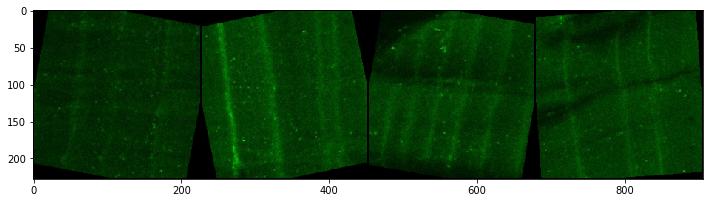

In [31]:
for img, label in train_loader:
    break
    
im = make_grid(img,nrow=12)
plt.figure(figsize=(12,4))
print(label)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [32]:
torch.cuda.empty_cache()
modelB = alexnet
modelB.to(device = dynDevice())

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [33]:
epochs = 1500
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []



for i in range(0,epochs): 
    
    epoch_start = time.time()
    i=0
    losses=0
    accuracies=0

    modelB.train()
    for img, label in train_loader:
        i+=1
        img, label = img.to(device = dynDevice()), label.to(device = dynDevice(), dtype=torch.float32)
        result = modelB(img)
        loss = criterionB(result,label.view(-1,1))
        losses+=loss.item()
        
        #Accuracies: is the quality well constrained? if so, are the layers correctly determined? 
        accuracies+= (result.detach().cpu().numpy().flatten().round() == label.detach().cpu().numpy().round()).sum()        

#        if i%100 ==0:
#            print(f'Training BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies/i}')
#            break
        
        
        #Update Model
        optimizerB.zero_grad()
        loss.backward()
        optimizerB.step()
        

  
        
    training_losses.append(losses/i) 
    training_accuracies.append(accuracies/(i*batchSize))
    training_end =time.time()

    #Validate
    i=0
    losses=0
    accuracies=0
    modelB.eval()
    with torch.no_grad():
        for img, label in valid_loader:
            i+=1
            img, label = img.to(device = dynDevice()), label.to(device = dynDevice(),dtype=torch.float32)
            result = modelB(img)
            loss = criterionB(result,label.view(-1,1))
            losses+=loss.item()
            accuracies+= (result.detach().cpu().numpy().flatten().round() == label.detach().cpu().numpy().round()).sum()        
#            if i%100 ==0:
#                print(f'Training BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies/i}')
#                break

        
        validation_losses.append(losses/i)   
        validation_accuracies.append(accuracies/(i*batchSize))
        validation_end = time.time()
    
    print(f'The epoch took {(validation_end-epoch_start):.0f}s. \n    training took {(training_end-epoch_start):.0f}s \n    validation took {(validation_end-training_end):.0f}s')

    print(f'Losses were \n    training loss: {training_losses[-1]:.3f} \n    validation loss: {validation_losses[-1]:.3f}')
    
    print(f'Accuracies were \n    training accuracy: {training_accuracies[-1]:.3f} \n    validation accuracy: {validation_accuracies[-1]:.3f}\n\n\n\n')
    

    

The epoch took 16s. 
    training took 15s 
    validation took 1s
Losses were 
    training loss: 1.601 
    validation loss: 1.530
Accuracies were 
    training accuracy: 0.189 
    validation accuracy: 0.158




The epoch took 16s. 
    training took 15s 
    validation took 1s
Losses were 
    training loss: 1.416 
    validation loss: 1.515
Accuracies were 
    training accuracy: 0.196 
    validation accuracy: 0.158




The epoch took 17s. 
    training took 15s 
    validation took 1s
Losses were 
    training loss: 1.419 
    validation loss: 1.497
Accuracies were 
    training accuracy: 0.195 
    validation accuracy: 0.151




The epoch took 16s. 
    training took 15s 
    validation took 1s
Losses were 
    training loss: 1.392 
    validation loss: 1.478
Accuracies were 
    training accuracy: 0.192 
    validation accuracy: 0.158




The epoch took 16s. 
    training took 15s 
    validation took 1s
Losses were 
    training loss: 1.328 
    validation loss: 1.411
Accurac

KeyboardInterrupt: 

In [ ]:
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend()

In [ ]:
result

In [ ]:
print(label)